## Time Series Analysis

#### Time Series on Daily Minimum Temperatures

### Matthew Yeseta


In [1]:

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from scipy.signal import periodogram

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### TIme Series Class for Analysis and Feature Engineering

In [2]:
class TimeSeriesAnalysis:
    def __init__(self, filepath):
        self.series = pd.read_csv(filepath, header=0, index_col=0, parse_dates=True)
        self.series = self.series.squeeze("columns")  # Squeeze to convert to Series if necessary
        self.series = self._ensure_complete_date_range(self.series)

        if not self.series.index.freq:
            inferred_freq = pd.infer_freq(self.series.index)
            if inferred_freq:
                self.series = self.series.asfreq(inferred_freq)  # Infer frequency if not set
            else:
                raise ValueError("Unable to infer frequency from the time series index.")
        self.dataframe = self._prepare_dataframe()

    def _ensure_complete_date_range(self, series):
        date_range = pd.date_range(start=series.index.min(), end=series.index.max(), freq='D')
        return series.reindex(date_range).fillna(method='ffill')

    def _prepare_dataframe(self):
        dataframe = pd.DataFrame()
        dataframe['month'] = self.series.index.month
        dataframe['day'] = self.series.index.day
        dataframe['temperature'] = self.series.values
        return dataframe

    def lag_features(self, lag=1):
        temps = pd.DataFrame(self.series.values)
        dataframe = pd.concat([temps.shift(lag), temps], axis=1)
        dataframe.columns = ['t', f't+{lag}']
        return dataframe

    def multiple_lag_features(self, lags=[3, 2, 1]):
        temps = pd.DataFrame(self.series.values)
        dataframe = pd.concat([temps.shift(lag) for lag in lags] + [temps], axis=1)
        dataframe.columns = [f't-{lag}' for lag in reversed(lags)] + ['t+1']
        return dataframe

    def rolling_window_features(self, window_size=2):
        temps = pd.DataFrame(self.series.values)
        shifted = temps.shift(1)
        window = shifted.rolling(window=window_size)
        means = window.mean()
        dataframe = pd.concat([means, temps], axis=1)
        dataframe.columns = ['mean(t-1,t)', 't+1']
        return dataframe

    def expanding_window_features(self):
        temps = pd.DataFrame(self.series.values)
        window = temps.expanding()
        dataframe = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
        dataframe.columns = ['min', 'mean', 'max', 't+1']
        return dataframe

    def arima_forecasting(self, order=(5,1,0)):
        model = ARIMA(self.series, order=order)
        model_fit = model.fit()
        print(model_fit.summary())
        forecast = model_fit.forecast(steps=10)
        return forecast

    def stl_decomposition(self, period=None):
        # Determine period dynamically if not provided
        if period is None:
            period = 365 if len(self.series) >= 365 else 12  # Assume daily data with yearly seasonality or monthly seasonality
        try:
            stl = STL(self.series, seasonal=period)
            result = stl.fit()
            result.plot()
            plt.show()
            return result
        except ValueError as e:
            print(f"Error in STL decomposition: {e}")
            if "Unable to determine period" in str(e):
                print("Attempting with a different period...")
                # Try with a different period
                period = 12
                stl = STL(self.series, seasonal=period)
                result = stl.fit()
                result.plot()
                plt.show()
                return result
            else:
                raise e

    def spectral_analysis(self):
        f, Pxx_den = periodogram(self.series)
        plt.figure()
        plt.semilogy(f, Pxx_den)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.show()

    def spectral_analysis(self):
        f, Pxx_den = periodogram(self.series)
        plt.figure()
        plt.semilogy(f, Pxx_den)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.show()

    def plot_yearly_data(self):
        groups = self.series.groupby(Grouper(freq='A'))
        years = DataFrame()
        for name, group in groups:
            # Ensure the group is reindexed to a full year
            date_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
            group = group.reindex(date_range).fillna(method='ffill')
            years[name.year] = group.values
        years.plot(subplots=True, legend=False)
        plt.show()

    def plot_boxplot(self):
        self.dataframe.boxplot(column='temperature', by='month')
        plt.title('Monthly Temperature Boxplot')
        plt.suptitle('')
        plt.xlabel('Month')
        plt.ylabel('Temperature')
        plt.show()

    def plot_matshow(self):
        pivoted = self.dataframe.pivot_table(values='temperature', index='day', columns='month')
        plt.matshow(pivoted, aspect='auto', origin='lower')
        plt.title('Temperature Matrix')
        plt.xlabel('Month')
        plt.ylabel('Day')
        plt.colorbar(label='Temperature')
        plt.show()

    def plot_lag(self):
        lag_plot(self.series)
        plt.title('Lag Plot')
        plt.show()

    def plot_autocorrelation(self):
        autocorrelation_plot(self.series)
        plt.title('Autocorrelation Plot')
        plt.show()

    def plot_density(self):
        self.series.plot(kind='kde')
        plt.title('Density Plot')
        plt.show()

    def plot_histogram(self):
        self.series.hist()
        plt.title('Histogram')
        plt.show()

    def plot_yearly(self):
        groups = self.series.groupby(Grouper(freq='A'))
        for name, group in groups:
            plt.figure()
            plt.plot(group)
            plt.title(f'Year {name.year}')
            plt.show()


In [3]:
# Example usage
tsa = TimeSeriesAnalysis('daily-minimum-temperatures.csv')

# Print the initial dataframe
print(tsa.dataframe.head(5))

   month  day  temperature
0      1    1         20.7
1      1    2         17.9
2      1    3         18.8
3      1    4         14.6
4      1    5         15.8


In [4]:
print(type(tsa))

<class '__main__.TimeSeriesAnalysis'>


In [5]:
# Lag features
print(tsa.lag_features(lag=1).head(5))

      t   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8


In [6]:
# Multiple lag features
print(tsa.multiple_lag_features(lags=[3, 2, 1]).head(5))

    t-1   t-2   t-3   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8


In [7]:
# Rolling window features
print(tsa.rolling_window_features(window_size=2).head(5))

   mean(t-1,t)   t+1
0          NaN  20.7
1          NaN  17.9
2        19.30  18.8
3        18.35  14.6
4        16.70  15.8


In [8]:
# Expanding window features
print(tsa.expanding_window_features().head(5))

    min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8


In [9]:
# ARIMA forecasting
forecast = tsa.arima_forecasting(order=(5,1,0))
print("Forecast:", forecast)

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3652
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8499.432
Date:                Mon, 22 Jul 2024   AIC                          17010.864
Time:                        16:17:00   BIC                          17048.081
Sample:                    01-01-1981   HQIC                         17024.118
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3358      0.015    -22.501      0.000      -0.365      -0.307
ar.L2         -0.3908      0.016    -24.084      0.000      -0.423      -0.359
ar.L3         -0.2948      0.017    -17.066      0.0

#### Data Visualization
 STL decomposition
 Spectral Analysis.
 Line Plots.
 Histograms and Density Plots.
 Box and Whisker Plots.
 Heat Maps.
 Lag Plots or Scatter Plots.
 Autocorrelation Plots.

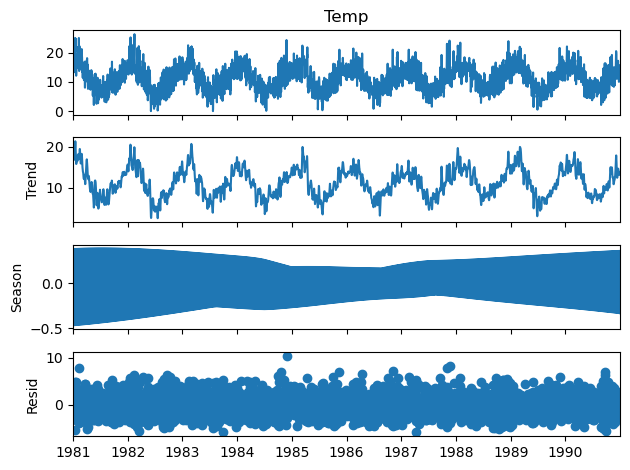

In [10]:
# STL decomposition
stl_result = tsa.stl_decomposition(period=365)

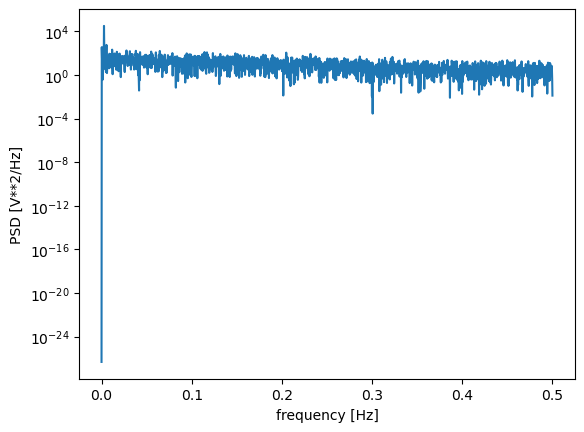

In [11]:
# Spectral analysis
tsa.spectral_analysis()

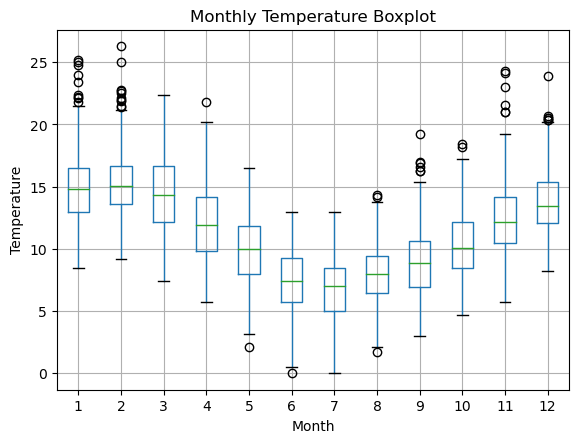

In [12]:
# Plot boxplot
tsa.plot_boxplot()

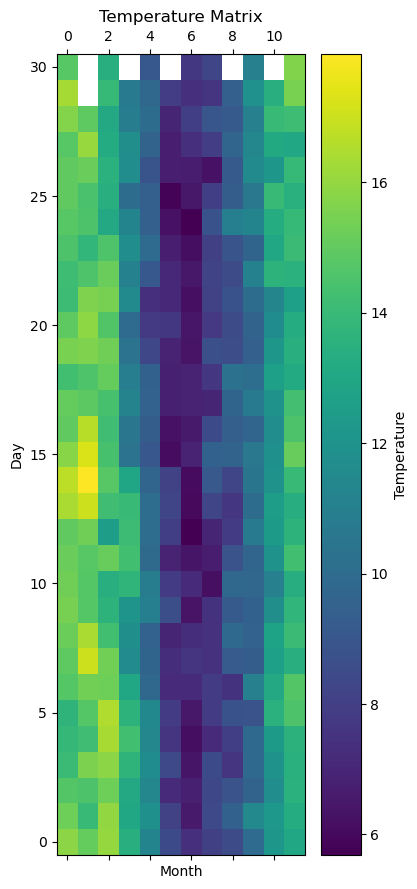

In [13]:
# Plot matshow
tsa.plot_matshow()

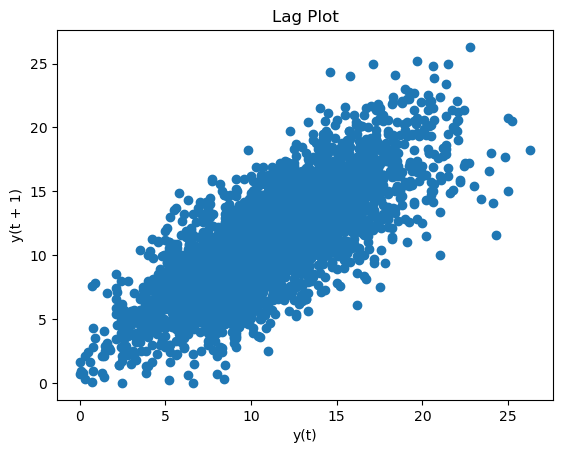

In [14]:
# Plot lag
tsa.plot_lag()

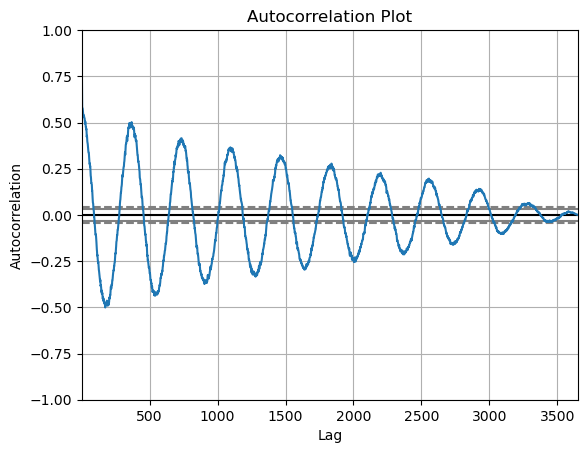

In [15]:
# Plot autocorrelation
tsa.plot_autocorrelation()

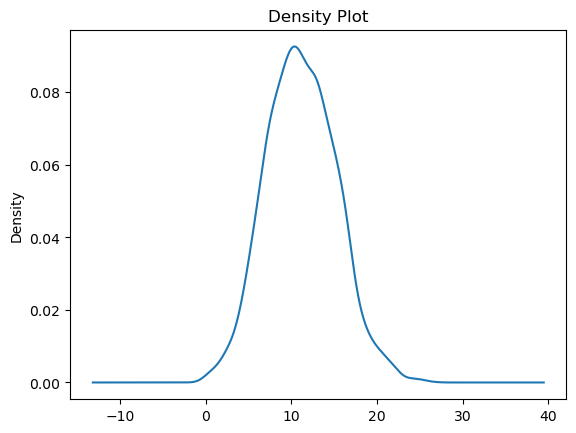

In [16]:
# Plot density
tsa.plot_density()

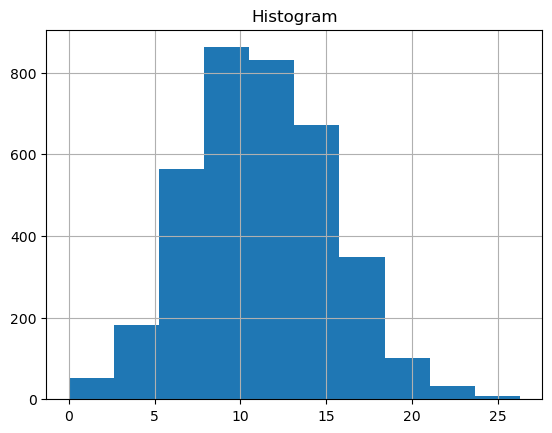

In [17]:
# Plot histogram
tsa.plot_histogram()

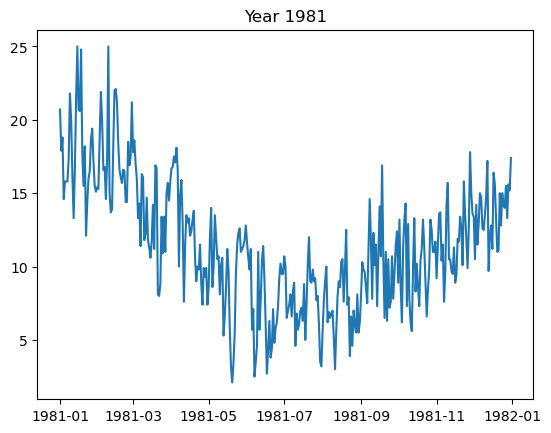

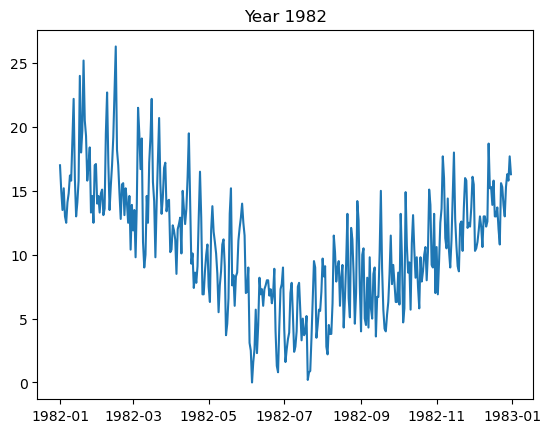

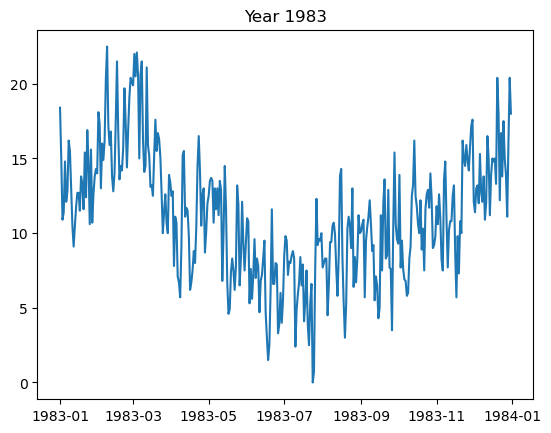

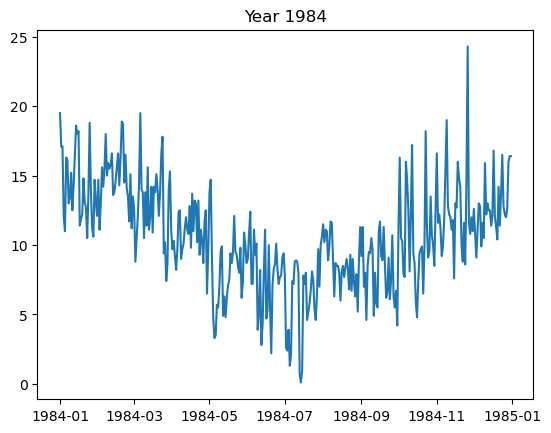

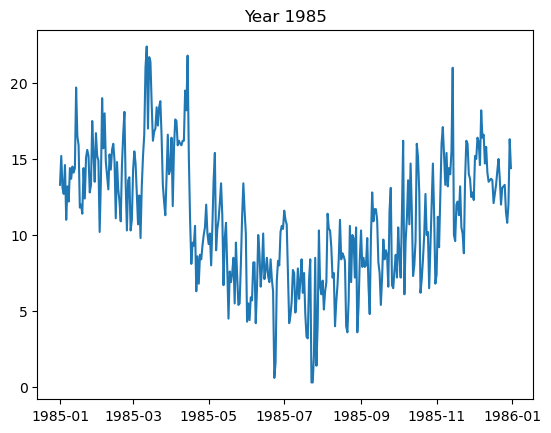

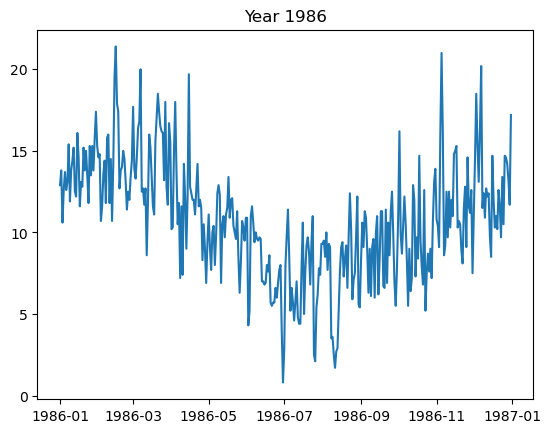

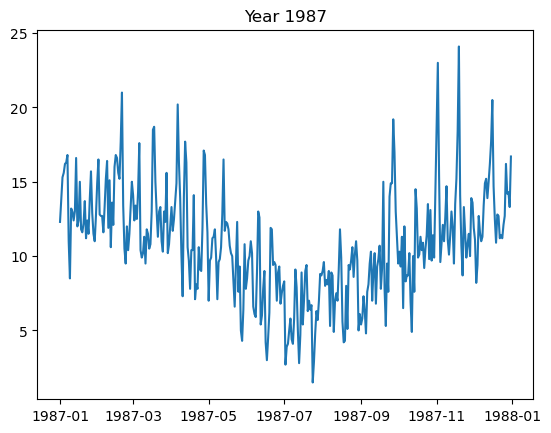

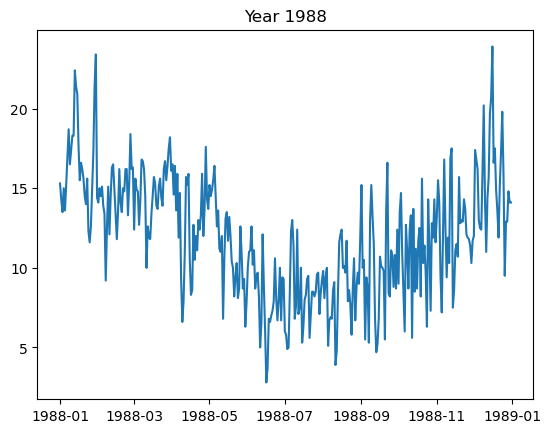

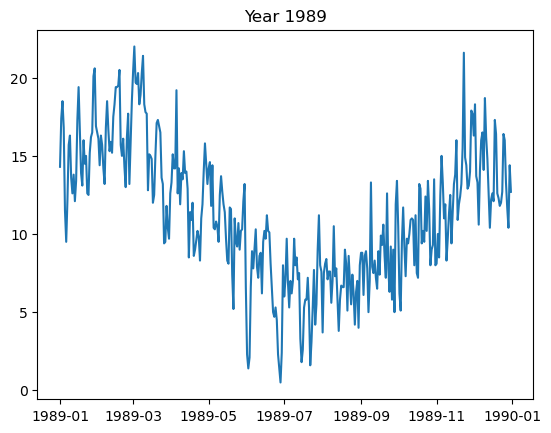

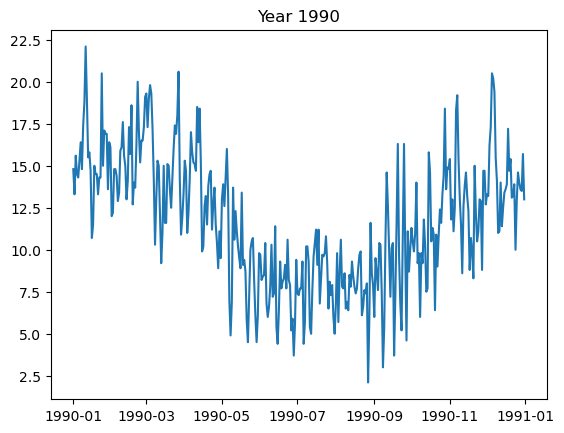

In [18]:
# Plot yearly
tsa.plot_yearly()

we see cycles of strong negative and positive correlation. This captures the relationship of an observation with past observations in the same and opposite seasons or times of year. Sine waves like those seen in this example are a strong sign of seasonality in the dataset.